# CE-40717: Machine Learning Final Project 

# MLP

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from torch import optim

import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load Dataset

In [3]:
# Tensorize and Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

# Load Train split
train_val_data = torchvision.datasets.FashionMNIST(
    root="./data", 
    train=True, 
    download=True, 
    transform=transform,
)

# Split train into train and validation sets
n_train = int(len(train_val_data) * 0.9)
n_val = len(train_val_data) - n_train

train_data, valid_data = random_split(train_val_data, [n_train, n_val])

# Load Test split
test_data = torchvision.datasets.FashionMNIST(
    root="./data", 
    train=False, 
    download=True, 
    transform=transform,
) 

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
batch_size=32

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [5]:
print(len(train_loader.dataset), "train samples")
print(len(valid_loader.dataset), "validation samples")
print(len(test_loader.dataset), "test samples")

54000 train samples
6000 validation samples
10000 test samples


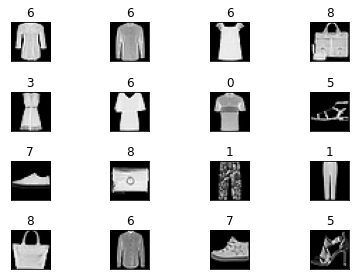

In [6]:
def visualize_data(dataset):
  """
  Visualize 16 samples from given dataset with corresponding labels
  """
  samples = iter(dataset)
  images, labels = samples.next()

  for i in range(16):
    ax = plt.subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(images[i][0], cmap='gray')
    ax.set_title(labels[i].item())
    
  plt.tight_layout() 
  plt.show()

visualize_data(train_loader)

## Learning

In [7]:
train_shape = train_data.dataset.data.shape
input_size = train_shape[1] * train_shape[2]
output_size = 10  # num of classes

### Model Definition

In [8]:
hidden_layers = (128, 64, 64)

def create_new_mlp_model():
  """
  Create and return a MLP model as specified below
  """
  model = nn.Sequential(
      nn.Linear(input_size, hidden_layers[0]),
      nn.ReLU(),
      nn.Linear(hidden_layers[0], hidden_layers[1]),
      nn.ReLU(),
      nn.Linear(hidden_layers[1], hidden_layers[2]),
      nn.ReLU(),
      nn.Linear(hidden_layers[2], output_size),
  )
  model.to(device)
  return model

# Get a model and print layers to verify they are correct
model = create_new_mlp_model()
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
)


### Train Loop

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=False):
  """
  Train the 'model' one time on all samples from 'dataloader' using 
  loss function 'loss_fn' and optimizer 'optimizer'.
  Set 'verbose' to True result in printing loss each 100 iteration.
  """

  model.train() # train mode

  dataset_size = len(dataloader.dataset)
  n_batches = len(dataloader)

  running_loss = 0

  for i, (images, labels) in enumerate(dataloader):
      # Flatten the images
      # (16, 1, 28, 28) -> (16, 1*28*28)
      images = images.view(images.shape[0], -1)

      # Move images and labels to device
      images = images.to(device)
      labels = labels.to(device)
      
      # Setting gradient to zeros to prevent accumulating gradients
      optimizer.zero_grad()        

      # Forward pass
      output = model(images)
      loss = loss_fn(output, labels)
      
      # Backward pass
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()

      if verbose and (i+1) % 100 == 0:    
        print(f"Iteration [{i+1:>4d}/{n_batches:>4d}] - Loss: {loss.item():.5f}")

  epoch_loss = running_loss / n_batches
  return epoch_loss


### Test Loop

In [10]:
def test_loop(dataloader, model, loss_fn, verbose=False):
  """
  Test the 'model' on samples from 'dataloader' using 
  loss function 'loss_fn' and return loss and accuracy.
  Set 'verbose' to True to print loss and accuracy.
  """

  model.eval() # evaluation mode

  dataset_size = len(dataloader.dataset)
  n_batches = len(dataloader)
  
  test_loss = 0
  n_correct = 0
  
  with torch.no_grad():
    for images, labels in dataloader:
      # Flatten the images
      # (16, 1, 28, 28) -> (16, 1*28*28)
      images = images.view(images.shape[0], -1)

      # Move images and labels to device
      images = images.to(device)
      labels = labels.to(device)
      
      # Predict
      output = model(images)
      preds = output.argmax(dim=1)
      
      # Calculate loss
      loss = loss_fn(output, labels)      
      test_loss += loss.item()

      # Calculate number of correct predictions
      n_correct += (preds == labels).sum().item()

  test_loss = test_loss / n_batches

  acc = 100 * n_correct / dataset_size
  
  if verbose:
    print(f"Average loss:\t {test_loss:>8f}")
    print(f"Accuracy:\t {(acc):>0.1f}%")

  return test_loss, acc

### Training

In [40]:
def training(model, loss_fn, optimizer, scheduler,
             epochs, verbose=False, model_path='model_with_best_loss.pth'):
  """
  Main training loop. 
  In each loop, we first train a model one epoch using 'train_loop' function
  and then get the accuracy and loss on validation data and print the results.
  The model with lowest loss on validation data will be saved in 'model_path'.
  This will act as early stopping because we save the best model before 
  overfitting accures.
  """

  train_losses = []
  validation_losses = []

  print(f"[Epoch]  Train Loss - Validation Loss - Validation Accuracy")

  best_loss = None
  validation_accuracies = []

  for epoch in range(epochs):
    trian_loss = train_loop(train_loader, model, loss_fn, optimizer, verbose=verbose)
    validation_loss, validation_acc = test_loop(valid_loader, model, loss_fn, verbose=verbose)

    train_losses.append(trian_loss)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_acc)
    
    print(f"[{epoch+1:>2d}/{epochs:>2d}] Train Loss: {trian_loss:.5f} - \
    Val Loss: {validation_loss:.5f} - Val Acc: {validation_acc:>0.3f}%")
    
    # Save model with best validation loss
    if not best_loss or validation_loss < best_loss:
      best_loss = validation_loss
      torch.save(model, model_path)
    
    if scheduler:
      scheduler.step()

  return validation_accuracies, train_losses, validation_losses

#### Adam Optimizer

In [45]:
# Model
model = create_new_mlp_model()
model_path = 'best_adam.pth'

# Hyperparams
epochs = 30
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Training
validation_accuracies, train_losses, validation_losses = training(model, 
                                                                     loss_fn, 
                                                                     optimizer, 
                                                                     scheduler,
                                                                     epochs,
                                                                     model_path=model_path)

[Epoch]  Train Loss - Validation Loss - Validation Accuracy
[ 1/30] Train Loss: 0.52402 -     Val Loss: 0.41209 - Val Acc: 85.400%
[ 2/30] Train Loss: 0.37769 -     Val Loss: 0.37391 - Val Acc: 86.600%
[ 3/30] Train Loss: 0.33654 -     Val Loss: 0.34875 - Val Acc: 87.617%
[ 4/30] Train Loss: 0.30408 -     Val Loss: 0.32768 - Val Acc: 88.100%
[ 5/30] Train Loss: 0.28063 -     Val Loss: 0.31474 - Val Acc: 88.883%
[ 6/30] Train Loss: 0.26286 -     Val Loss: 0.32201 - Val Acc: 88.483%
[ 7/30] Train Loss: 0.24851 -     Val Loss: 0.30390 - Val Acc: 88.983%
[ 8/30] Train Loss: 0.23483 -     Val Loss: 0.30621 - Val Acc: 89.117%
[ 9/30] Train Loss: 0.22429 -     Val Loss: 0.30432 - Val Acc: 89.217%
[10/30] Train Loss: 0.21590 -     Val Loss: 0.29686 - Val Acc: 89.650%
[11/30] Train Loss: 0.20895 -     Val Loss: 0.29770 - Val Acc: 89.517%
[12/30] Train Loss: 0.20292 -     Val Loss: 0.29251 - Val Acc: 89.800%
[13/30] Train Loss: 0.19792 -     Val Loss: 0.29932 - Val Acc: 89.683%
[14/30] Train Los

In [46]:
print("Adam::Best accuracy of validation data:", max(validation_accuracies))

Adam::Best accuracy of validation data: 89.98333333333333


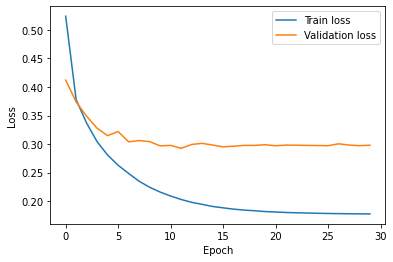

In [47]:
plt.plot(train_losses, label="Train loss")
plt.plot(validation_losses, label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#### SGD Optimizer

In [48]:
# Model
model = create_new_mlp_model()
model_path = 'best_sgd.pth'

# Hyperparams
epochs = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=0.8)

# Training
validation_accuracies, train_losses, validation_losses = training(model, 
                                                                     loss_fn, 
                                                                     optimizer, 
                                                                     scheduler,
                                                                     epochs,
                                                                     model_path=model_path)

[Epoch]  Train Loss - Validation Loss - Validation Accuracy
[ 1/30] Train Loss: 1.08246 -     Val Loss: 0.60868 - Val Acc: 77.450%
[ 2/30] Train Loss: 0.55363 -     Val Loss: 0.50732 - Val Acc: 81.867%
[ 3/30] Train Loss: 0.47912 -     Val Loss: 0.46514 - Val Acc: 83.667%
[ 4/30] Train Loss: 0.44423 -     Val Loss: 0.45859 - Val Acc: 83.617%
[ 5/30] Train Loss: 0.42282 -     Val Loss: 0.42753 - Val Acc: 85.200%
[ 6/30] Train Loss: 0.40798 -     Val Loss: 0.41538 - Val Acc: 85.317%
[ 7/30] Train Loss: 0.39703 -     Val Loss: 0.40628 - Val Acc: 85.650%
[ 8/30] Train Loss: 0.38895 -     Val Loss: 0.40232 - Val Acc: 85.767%
[ 9/30] Train Loss: 0.38246 -     Val Loss: 0.39348 - Val Acc: 85.950%
[10/30] Train Loss: 0.37767 -     Val Loss: 0.39584 - Val Acc: 85.983%
[11/30] Train Loss: 0.37349 -     Val Loss: 0.39100 - Val Acc: 86.067%
[12/30] Train Loss: 0.37083 -     Val Loss: 0.38821 - Val Acc: 86.100%
[13/30] Train Loss: 0.36810 -     Val Loss: 0.38659 - Val Acc: 86.400%
[14/30] Train Los

In [50]:
print("SGD::Best accuracy of validation data:", max(validation_accuracies))

SGD::Best accuracy of validation data: 86.55


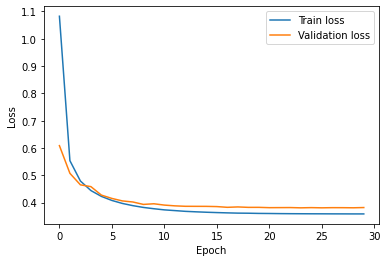

In [51]:
plt.plot(train_losses, label="Train loss")
plt.plot(validation_losses, label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Evaluation

In [52]:
model = torch.load('best_adam.pth')
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
)

In [53]:
print("\nTrain result")
test_loop(train_loader, model, loss_fn, verbose=True)

print("\nValidation result")
test_loop(valid_loader, model, loss_fn, verbose=True)

print("\nTest result")
test_loss, test_acc = test_loop(test_loader, model, loss_fn, verbose=True)


Train result
Average loss:	 0.197951
Accuracy:	 92.9%

Validation result
Average loss:	 0.294213
Accuracy:	 89.8%

Test result
Average loss:	 0.321061
Accuracy:	 88.9%


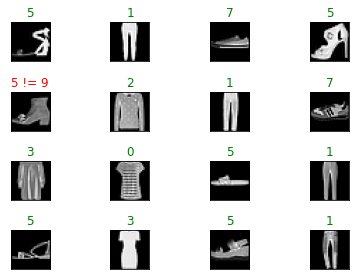

In [54]:
samples = iter(test_loader)
images, labels = samples.next()
images_device = images.view(images.shape[0], -1).to(device)
outputs = model(images_device)
preds = outputs.argmax(dim=1)

for i in range(16):
  ax = plt.subplot(4, 4, i+1, xticks=[], yticks=[])
  ax.imshow(images[i][0], cmap='gray')
  if labels[i].item() == preds[i].item():
    ax.set_title(labels[i].item(), color="green")
  else:
    ax.set_title(f"{preds[i].item()} != {labels[i].item()}", color="red")
  
plt.tight_layout() 
plt.show()